# Integrating breast cancer datasets using EmbedMNN model

In this example, we will use *transmorph* to integrate lung datasets from three patients, gathered in [1]. These datasets contain a total of approximately 100,000 cells, annotated by cell type. Each dataset is embedded in its own 10,000 most variable gene space, and we exploit the intersection of these gene spaces to carry out dataset integration.

We use one of our built-in models, **EmbedMNN**, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2, 3] and a low-dimensional space embedding using UMAP [4] or MDE [5]. This low dimensional space can subsequently be used to carry out tasks such as clustering.

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Breast cancer databank contains five datasets in the AnnData format, each expressed in its 10,000 most variable genes space. Cells are annotated by the .obs key "class_type". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [1]:
from transmorph.datasets import load_pal_10x

# Format: {patient_label -> AnnData}
pal_10x = load_pal_10x()

# We convert it to List[AnnData] as we do not 
# care about label here
datasets = list(pal_10x.values())

databank_api > Loading bank pal_10x.


We can first observe the cell type distribution in each dataset. As we can see, batch 3 contains an exclusive cell type (endothelial cells), and batch 4 contains almost exclusively epithelial cells and fibroblast. This suggests the integration to be nontrivial, as there is a high cell type imbalance between batches.

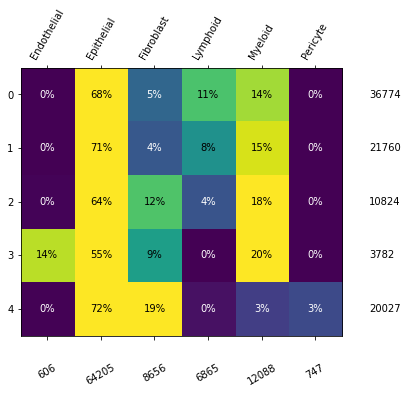

In [2]:
from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(datasets, "class_type")

### Plotting initial datasets using scatter_plot

*transmorph.plotting.reduce_dimension* can be used to compute a low dimensional representation of a set of datasets, and save the output in the respective AnnData objects under an access key. Batches can then be represented using *transmmorph.plotting.scatter_plot*.

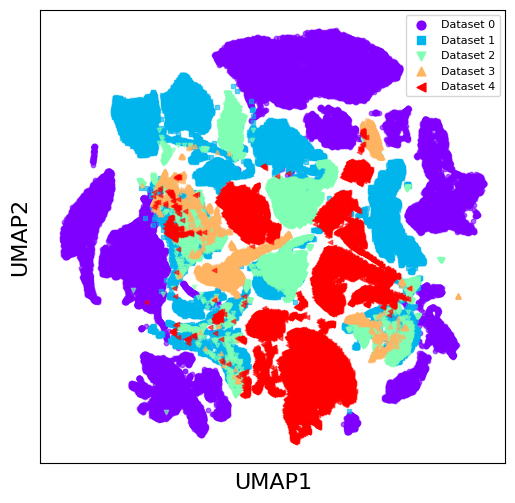

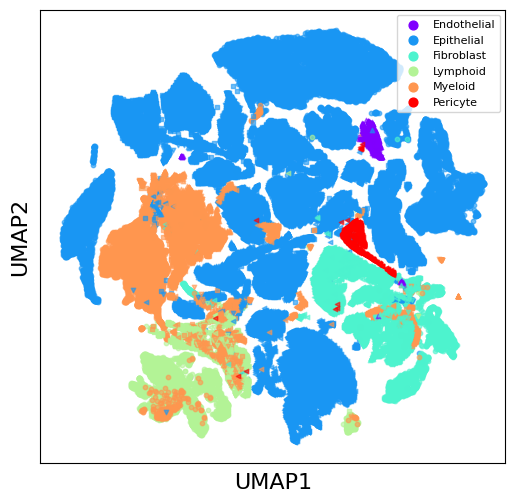

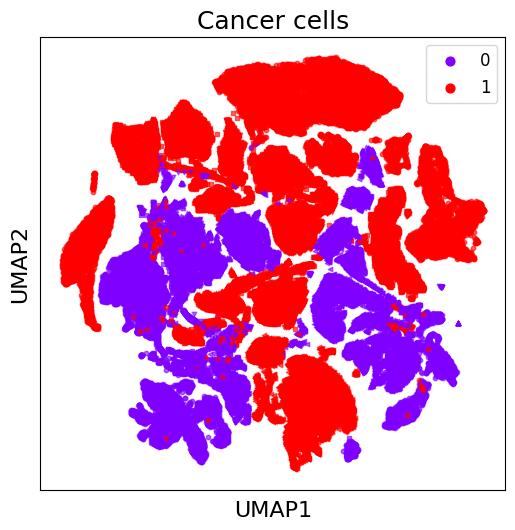

In [5]:
from transmorph.utils.plotting import scatter_plot, reduce_dimension

reduce_dimension(datasets, output_obsm="before_transmorph")

# use_cache=True allows to avoid recomputing a UMAP representation for each plot
scatter_plot(
    datasets, 
    input_obsm="before_transmorph"
)
scatter_plot(
    datasets, 
    color_by="class_type",
    input_obsm="before_transmorph"
)
scatter_plot(
    datasets, 
    color_by="class_iscancer",
    input_obsm="before_transmorph",
    title="Cancer cells"
)

As we can see, batch effect is very strong even in the common gene space. In this state, it is impossible to attempt a clustering algorithm for instance, as cells are clustered per batch as clearly as per cell type. *transmorph* is equiped with pre-built integration models to integrate these batches so that similar cell types cluster together.

### Dataset integration using EmbedMNN

**EmbedMNN** combines an inter-batch nearest neighbors step followed with a low-dimensional embedding, here using UMAP. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects. It will add a .obsm["transmorph"] entry, corresponding to the integrated view computed. While the nearest neighbors step should easily handle datasets of this size, the UMAP optimizer can take some time when dealing with 100,000 cells, connected with millions of edges. It should nonetheless remain reasonable, even on a laptop.

**This model starts by embedding all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [2]:
from transmorph.models import EmbedMNN

# Using these two parameters, we can tune the balance
# between matching edges and knn edges.
model = EmbedMNN(obs_class="class_type") 
model.transform(datasets)

EMBED_MNN > Transmorph model is initializing.
EMBED_MNN > Ready to start the integration of 5 datasets, 93167 total samples.
EMBED_MNN > Running layer LAYER_INPUT#0.
EMBED_MNN > Running layer LAYER_TRANSFORMATION#1.
EMBED_MNN > Running layer LAYER_MATCHING#2.
LAYER_MATCHING#2 > Calling matching MATCHING_MNN.
EMBED_MNN > Running layer LAYER_MERGING#3.
LAYER_MERGING#3 > Running merging MERGING_GRAPH_EMBEDDING...
EMBED_MNN > Running layer LAYER_OUTPUT#4.
EMBED_MNN > Terminated. Total embedding shape: (93167, 2)


# Post-integration analysis

Transmorph offers a series of tools to process and interpret integration output.

We can first use *scatter_plot* once again, providing the access key "transmorph" as the output dimensionality is already 2D. As we can see, **EmbedMNN** successfully captures cell types across batches, and provides a coherent integrated representation of batches.

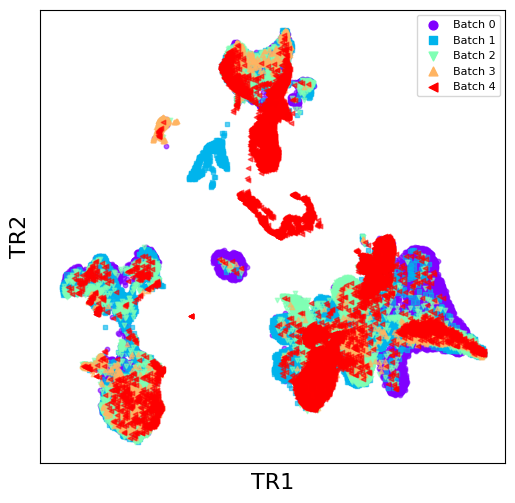

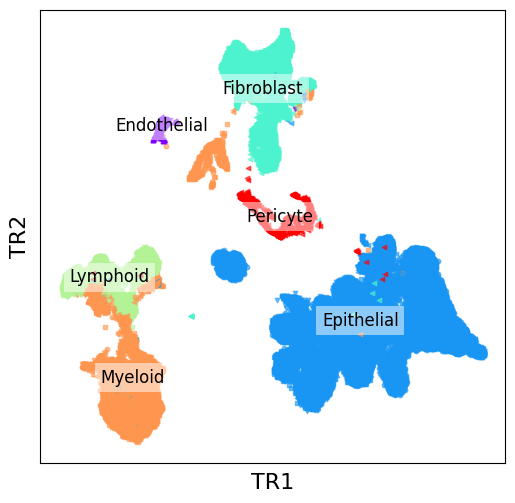

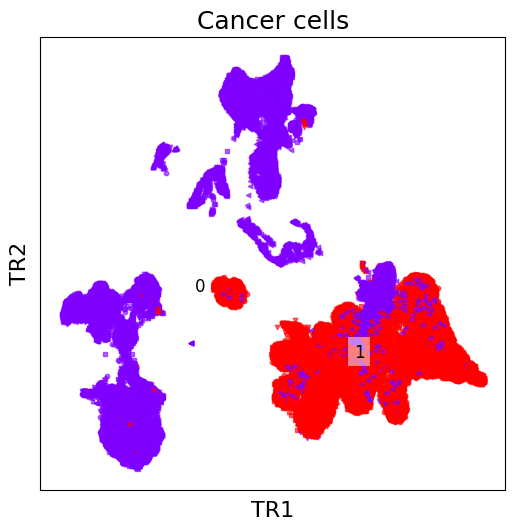

In [3]:
from transmorph.utils.plotting import scatter_plot

scatter_plot(datasets, input_obsm="transmorph", xlabel="TR1", ylabel="TR2")
scatter_plot(
    datasets, color_by="class_type", show_legend=False, plot_cluster_names=True, 
    input_obsm="transmorph", xlabel="TR1", ylabel="TR2"
)
scatter_plot(
    datasets, color_by="class_iscancer", show_legend=False, plot_cluster_names=True, 
    input_obsm="transmorph", xlabel="TR1", ylabel="TR2", title="Cancer cells"
)

An important pipeline step of EmbedMNN is the matching across batches, carried out via MNN or bach k-NN. The *plot_matching_eval* method allows to see, for each pair of datasets, and given a label ground truth, how accurate edges. Accuracy 1.0 means all edges connect samples of the same class, and 0.0 means complete matching failure for the given labels. As we can see, in our case cell type matching was near perfect.

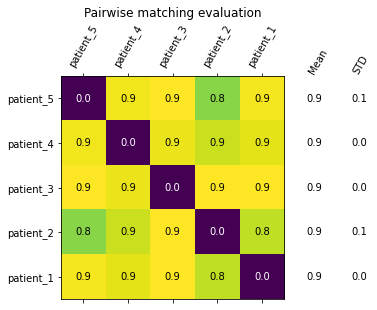

In [4]:
from transmorph.utils.plotting import plot_matching_eval

plot_matching_eval(model, datasets, obs="class_type", dataset_keys=pal_10x.keys())

## References

[1] Pal, B. et al. *A single‐cell RNA expression atlas of normal, preneoplastic and tumorigenic states in the human breast*. **The EMBO journal** (2021), 40(11), e107333.

[2] Haghverdi, Laleh, et al. *Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.* **Nature biotechnology** 36.5 (2018): 421-427.

[3]  Polański, Krzysztof, et al. *BBKNN: fast batch alignment of single cell transcriptomes.* **Bioinformatics** 36.3 (2020): 964-965.

[4] Becht, Etienne, et al. *Dimensionality reduction for visualizing single-cell data using UMAP.* **Nature biotechnology** 37.1 (2019): 38-44.

[5] Agrawal, Akshay, Alnur Ali, and Stephen Boyd. *Minimum-distortion embedding.* **arXiv preprint** arXiv:2103.02559 (2021).